In [171]:
import gym
import gym_minigrid
# import mctx
import jax
import flax
import rlax

In [172]:
from gym_minigrid.wrappers import *
env = gym.make('MiniGrid-Empty-8x8-v0')
full_env = ImgObsWrapper(FullyObsWrapper(env))
obs = full_env.reset();

In [173]:
from gym_minigrid.minigrid import Grid
from types import MethodType
def new_render(self, tile_size, agent_pos=None, agent_dir=None, highlight_mask=None):
    return Grid.render(self, tile_size, agent_pos, agent_dir, highlight_mask=None)
full_env.grid.render = MethodType(new_render, full_env.grid)

In [174]:
env.action_space

Discrete(7)

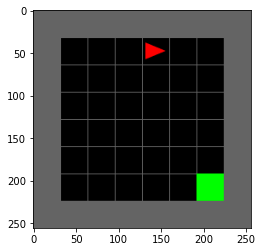

In [188]:
import matplotlib.pyplot as plt
plt.imshow(full_env.render(mode='nonhuman'))

In [127]:
obs

array([[[ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [10,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],


In [176]:
def view_obs(observation):
    tmp_env = FullyObsWrapper(gym.make('MiniGrid-Empty-8x8-v0'))
    tmp_env.reset()
    index = np.where(observation[:, :, 0] == 10)
    tmp_env.agent_pos = index[0][0], index[1][0]
    tmp_env.agent_dir = observation[tmp_env.agent_pos[0], tmp_env.agent_pos[1], 2]
    obs_ = np.copy(observation)
    obs_[tmp_env.agent_pos[0], tmp_env.agent_pos[1], :] = 0
    tmp_env.grid = tmp_env.grid.decode(obs_)
    plt.imshow(tmp_env.render(mode='nonhuman'))
    plt.show()

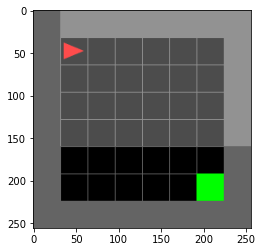

In [177]:
view_obs(obs)

In [186]:
obs, reward, done, info = full_env.step(2)

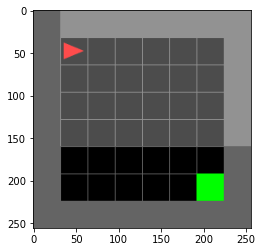

In [187]:
view_obs(obs)

In [180]:
def get_next_embedding(observation, action):
    tmp_env = ImgObsWrapper(FullyObsWrapper(gym.make('MiniGrid-Empty-8x8-v0')))
    tmp_env.reset()
    index = np.where(observation[:, :, 0] == 10)
    tmp_env.agent_pos = index[0][0], index[1][0]
    tmp_env.agent_dir = observation[tmp_env.agent_pos[0], tmp_env.agent_pos[1], 2]
    obs_ = np.copy(observation)
    obs_[tmp_env.agent_pos[0], tmp_env.agent_pos[1], :] = 0
    tmp_env.grid = tmp_env.grid.decode(obs_)
    plt.imshow(tmp_env.render(mode='nonhuman'))
    plt.show()
    observation_, reward, done, info = tmp_env.step(action)
    plt.imshow(tmp_env.render(mode='nonhuman'))
    plt.show()
    return observation_, reward

In [181]:
obs

array([[[ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [10,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],


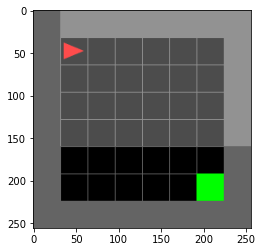

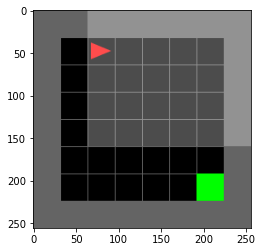

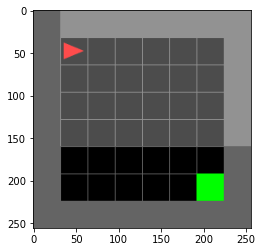

In [190]:
view_obs(get_next_embedding(obs, 2)[0])

In [83]:
def recurrent_fn(params, rng_key, action, embedding):
    next_embedding, reward = get_next_embedding(embedding, action)
    recurrent_fn_output = mctx.RecurrentFnOutput(
        reward=reward,
        discount=0.99,
        prior_logits=params['prior_logits'](embedding),
        value=params['value_network'](embedding))
    return recurrent_fn_output, next_embedding

In [99]:
import flax.linen as nn

class CNN(nn.Module):
    output_features: int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.output_features)(x)
        return x

policy_network = CNN(output_features=7)
variables = policy_network.init(jax.random.PRNGKey(0), observation['image'][None, ...])
value_network = CNN(output_features=1)


In [96]:
variables.keys()

frozen_dict_keys(['params'])

In [98]:
observation['image'].shape

(8, 8, 3)

In [100]:
policy_network.apply(variables, observation['image'][None, ...]).shape

(1, 7)

In [70]:
get_next_embedding(observation['image'], 6)

({'mission': 'get to the green goal square',
  'image': array([[[ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0]],
  
         [[ 2,  5,  0],
          [10,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 2,  5,  0]],
  
         [[ 2,  5,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 2,  5,  0]],
  
         [[ 2,  5,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 2,  5,  0]],
  
         [[ 2,  5,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,